# Coordinate-based meta-regression algorithms

A tour of CBMR algorithms in NiMARE.

This tutorial is intended to provide a brief description and example of the CBMR algorithm implemented in NiMARE. For a more detailed introduction to the elements of a coordinate-based meta-regression, see other stuff.

In [1]:
import nimare
import os 
from nimare.dataset import Dataset
from nimare.utils import get_masker, B_spline_bases, dummy_encoding_moderators
from nimare.tests.utils import standardize_field
from nimare.meta.cbmr import CBMREstimator, CBMRInference
from nimare.meta import models
from nilearn.plotting import plot_stat_map
from nimare.generate import create_coordinate_dataset
import nibabel as nib 
import numpy as np
import scipy


INFO:numexpr.utils:Note: NumExpr detected 24 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


## Load Dataset

In [2]:
# data simulation
ground_truth_foci, dset = create_coordinate_dataset(foci=10, sample_size=(20, 40), n_studies=1000)
# set up group columns: diagnosis & drug_status  
n_rows = dset.annotations.shape[0]
dset.annotations['diagnosis'] = ["schizophrenia" if i%2==0 else 'depression' for i in range(n_rows)]
dset.annotations['drug_status'] = ['Yes' if i%2==0 else 'No' for i in range(n_rows)]
dset.annotations['drug_status'] = dset.annotations['drug_status'].sample(frac=1).reset_index(drop=True) # random shuffle drug_status column
# set up moderators: sample sizes & avg_age
dset.annotations["sample_sizes"] = [dset.metadata.sample_sizes[i][0] for i in range(n_rows)] 
dset.annotations["avg_age"] = np.arange(n_rows)
# categorical moderator: schizophrenia_subtype
dset.annotations['schizophrenia_subtype'] = ['type1' if i%2==0 else 'type2' for i in range(n_rows)]
dset.annotations['schizophrenia_subtype'] = dset.annotations['schizophrenia_subtype'].sample(frac=1).reset_index(drop=True) # random shuffle drug_status column

## Estimate group-specific spatial intensity functions

INFO:nimare.diagnostics:0/10000 coordinates fall outside of the mask. Removing them.
/well/nichols/users/pra123/anaconda3/envs/torch/lib/python3.8/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


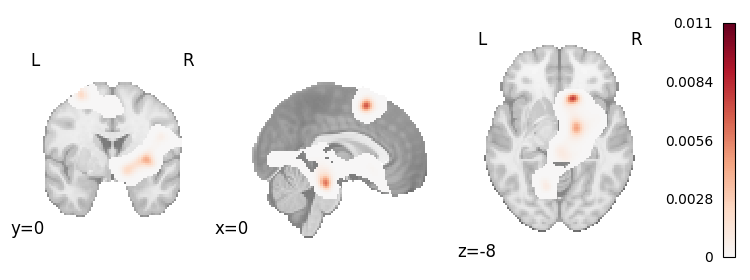

In [3]:
dset = standardize_field(dataset=dset, metadata=["sample_sizes", "avg_age"])
cbmr = CBMREstimator(
        group_categories=["diagnosis", "drug_status"],
        moderators=["standardized_sample_sizes", "standardized_avg_age"],
        spline_spacing=10,
        model=models.PoissonEstimator,
        penalty=False,
        lr=1e-1,
        tol=1,
        device="cpu",
    )
cbmr_res = cbmr.fit(dataset=dset)
plot_stat_map(
    cbmr_res.get_map("Group_schizophrenia_Yes_Studywise_Spatial_Intensity"),
    cut_coords=[0, 0, -8],
    draw_cross=False,
    cmap="RdBu_r",
)

## Generalized Linear Hypothesis (GLH) for Spatial homogeneity

INFO:nimare.meta.cbmr:Group Reference in contrast array
INFO:nimare.meta.cbmr:schizophrenia_No = index_0
INFO:nimare.meta.cbmr:depression_No = index_1
INFO:nimare.meta.cbmr:depression_Yes = index_2
INFO:nimare.meta.cbmr:schizophrenia_Yes = index_3
INFO:nimare.meta.cbmr:Moderator Reference in contrast array
INFO:nimare.meta.cbmr:standardized_sample_sizes = index_0
INFO:nimare.meta.cbmr:standardized_avg_age = index_1


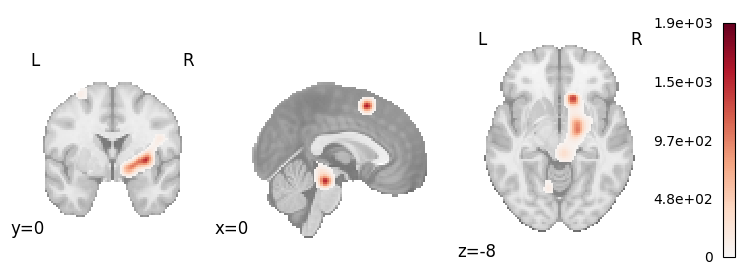

In [4]:
# homoogeneity test for each group
inference = CBMRInference(
    CBMRResults=cbmr_res, device="cuda"
)
t_con_groups = inference.create_contrast(["schizophrenia_Yes", "schizophrenia_No", "depression_Yes", "depression_No"], type="groups")
contrast_result = inference.compute_contrast(t_con_groups=t_con_groups, t_con_moderators=False)
    
plot_stat_map(
    cbmr_res.get_map("schizophrenia_No_chi_square_values"),
    cut_coords=[0, 0, -8],
    draw_cross=False,
    cmap="RdBu_r",
    threshold=30,
)

INFO:nimare.meta.cbmr:Group Reference in contrast array
INFO:nimare.meta.cbmr:schizophrenia_No = index_0
INFO:nimare.meta.cbmr:depression_No = index_1
INFO:nimare.meta.cbmr:depression_Yes = index_2
INFO:nimare.meta.cbmr:schizophrenia_Yes = index_3
INFO:nimare.meta.cbmr:Moderator Reference in contrast array
INFO:nimare.meta.cbmr:standardized_sample_sizes = index_0
INFO:nimare.meta.cbmr:standardized_avg_age = index_1


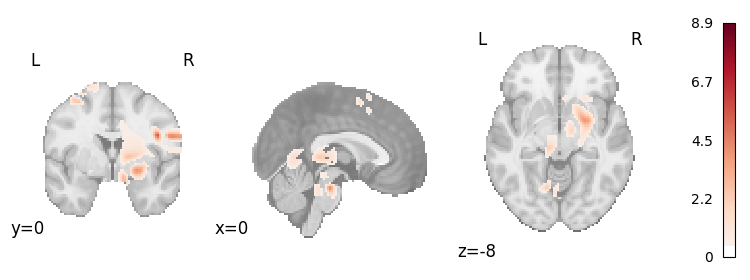

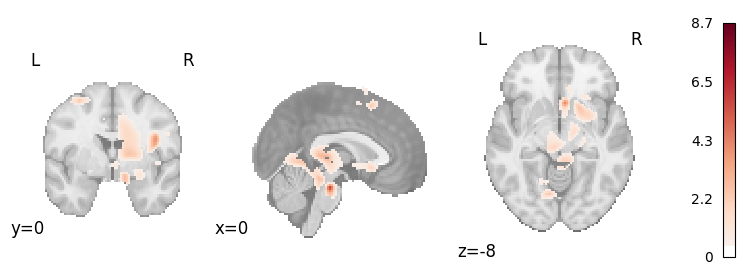

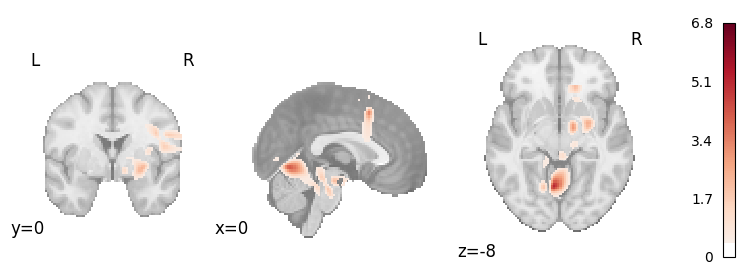

In [5]:
# Group comparison test between any two groups
inference = CBMRInference(
    CBMRResults=cbmr_res, device="cuda"
)
t_con_groups = inference.create_contrast(["schizophrenia_Yes-schizophrenia_No", "schizophrenia_No-depression_Yes", "depression_Yes-depression_No"], type="groups")
contrast_result = inference.compute_contrast(t_con_groups=t_con_groups, t_con_moderators=False)
# chi square statistics maps for group comparison test
plot_stat_map(
    cbmr_res.get_map("schizophrenia_Yes-schizophrenia_No_chi_square_values"),
    cut_coords=[0, 0, -8],
    draw_cross=False,
    cmap="RdBu_r",
    threshold=0.5,
)
plot_stat_map(
    cbmr_res.get_map("schizophrenia_No-depression_Yes_chi_square_values"),
    cut_coords=[0, 0, -8],
    draw_cross=False,
    cmap="RdBu_r",
    threshold=0.5,
)
plot_stat_map(
    cbmr_res.get_map("depression_Yes-depression_No_chi_square_values"),
    cut_coords=[0, 0, -8],
    draw_cross=False,
    cmap="RdBu_r",
    threshold=0.5,
)

## Generalized Linear Hypothesis (GLH) for study-level moderators

In [7]:
# Test for existence of effect of study-level moderators
inference = CBMRInference(
    CBMRResults=cbmr_res, device="cuda"
)
t_con_moderators = inference.create_contrast(["standardized_sample_sizes", "standardized_avg_age", "standardized_sample_sizes-standardized_avg_age"], type="moderators")
contrast_result = inference.compute_contrast(t_con_groups=False, t_con_moderators=t_con_moderators)
sample_size_p = cbmr_res.tables["standardized_sample_sizes_p_values"]
avg_age_p = cbmr_res.tables["standardized_avg_age_p_values"]
moderators_diff_p = cbmr_res.tables["standardized_sample_sizes-standardized_avg_age_p_values"]
print(f"For hypothesis test for existence of effect of study-level moderators (sample_size and avg_age), the p values are: {sample_size_p}, {avg_age_p}")
print(f"For hypothesis test for difference between effect of study-level moderators (sample_size and avg_age), the p values are: {moderators_diff_p}")

INFO:nimare.meta.cbmr:Group Reference in contrast array
INFO:nimare.meta.cbmr:schizophrenia_No = index_0
INFO:nimare.meta.cbmr:depression_No = index_1
INFO:nimare.meta.cbmr:depression_Yes = index_2
INFO:nimare.meta.cbmr:schizophrenia_Yes = index_3
INFO:nimare.meta.cbmr:Moderator Reference in contrast array
INFO:nimare.meta.cbmr:standardized_sample_sizes = index_0
INFO:nimare.meta.cbmr:standardized_avg_age = index_1


For hypothesis test for existence of effect of study-level moderators (sample_size and avg_age), the p values are: 0.9243109811987764, 0.9461743884065033
For hypothesis test for difference between effect of study-level moderators (sample_size and avg_age), the p values are: 0.8487350829759214
